# Simulation study

author: Milo Imbeni   
modified by: Steeve Laquitaine

## Setup

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import numpy as np
import bluepy as bp

import spikeinterface
import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import spikeinterface.sorters as ss
import spikeinterface.qualitymetrics as sqm
import spikeinterface.postprocessing as spost
from spikeinterface.comparison import GroundTruthStudy
from pprint import pprint

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = '6'

### Set environment variables

In [3]:
ss.Kilosort3Sorter.set_kilosort3_path('./sorters_packages/Kilosort')
ss.IronClustSorter.set_ironclust_path('./sorters_packages/ironclust')
ss.HDSortSorter.set_hdsort_path('./sorters_packages/HDsort')

Setting KILOSORT3_PATH environment variable for subprocess calls to: /gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/notebooks/old/sorters_packages/Kilosort
Setting IRONCLUST_PATH environment variable for subprocess calls to: /gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/notebooks/old/sorters_packages/ironclust
Setting HDSORT_PATH environment variable for subprocess calls to: ./sorters_packages/HDsort


### Set data path

In [4]:
# set paths
outpath = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/'
name = 'Hex0_4s_reyes128'
simpath = '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0'
out = outpath + name +'/' + name
outrec = out + '_rec'          # recording
outsort = out + '_true_spikes' # sorted spikes
study_folder = out + '_study'

## Load simulation 

* Simulation was created with `Neurodamus`.

In [5]:
# read simulation with bluepy
sim =  bp.Simulation(simpath + '/BlueConfig')
c = sim.circuit

Invalid absolute path: /gpfs/bbp.cscs.ch/project/proj45/scratch/S1full/METypes
Have keys ({'KeepModelData', 'LFPWeightsPath'}) that are not defined for section: Run


In [6]:
pprint("circuit attributes:\n")
pprint(vars(c))

'circuit attributes:\n'
{'_config': {'atlas': '/gpfs/bbp.cscs.ch/project/proj83/data/atlas/S1/MEAN/P14-MEAN',
             'cells': '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/circuit.mvd3',
             'connectome': '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/connectome/functional/edges.sonata',
             'emodels': '/gpfs/bbp.cscs.ch/project/proj45/scratch/S1full/METypes',
             'mecombo_info': '/gpfs/bbp.cscs.ch/project/proj83/singlecell/fixed_L6_allBPC_thresholds/mecombo_emodel.tsv',
             'morphologies': '/gpfs/bbp.cscs.ch/project/proj83/morphologies/fixed_ais_L23PC_20201210/ascii',
             'morphology_type': 'asc',
             'projections': {'Thalamocortical_input_VPM': '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/projections/2022_04_04/vpm_region_by_region_flatmap/merged.sonata'},
             'projections_metadata': {'Thalamocortical_input_VPM': {'Path': '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/p

In [7]:
# read recording dataset and sorted dataset
rec = spikeinterface.load_extractor(outrec)
gt_sorting0 = spikeinterface.load_extractor(outsort)
print(dir(gt_sorting0))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_check_segment_index', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_features', '_get_file_path', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_npz_kwargs', '_preferred_mp_context', '_properties', '_recording', '_sampling_frequency', '_save', '_sorting_segments', 'add_sorting_segment', 'annotate', 'check_if_dumpable', 'clone', 'copy_metadata', 'default_missing_property_values', 'delete_property', 'dump', 'dump_to_json', 'dump_to_pickle', 'extra_requirements', 'extractor_name', 'frame_slice', 'from_dict', 'get_all_spike_trains', 'get_annotation', 'get_annotation_keys', 'get_num

## Simulation description

In [8]:
# Describe dataset
print("unit count: ", gt_sorting0.get_num_units())
print("total spike count: ", sum(gt_sorting0.get_total_num_spikes().values()))

unit count:  854
total spike count:  3180


In [9]:
# get gids with less than 10 spikes
gt_dict = gt_sorting0.get_total_num_spikes()
min_spikes = 10
rare_gids = list(dict((k, v) for k, v in gt_dict.items() if v <= min_spikes).keys())
print("preview gids with less than 10 spikes:", rare_gids[:5])

preview gids with less than 10 spikes: [10250, 54138, 97717, 128161, 162868]


## Simulation curation

In [10]:
# describe simulation
print("describe units: ", gt_sorting0)

describe units:  NpzFolderSorting: 854 units - 1 segments - 20.0kHz


In [11]:
# remove units with less than 10 spikes
gt_sorting0 = gt_sorting0.remove_units(rare_gids)
print("describe curated units: ", gt_sorting0)

describe curated units:  UnitsSelectionSorting: 26 units - 1 segments - 20.0kHz


In [12]:
selected_channels = np.arange(64,80)
rec0 = rec.channel_slice(channel_ids=selected_channels)
print("describe selected channels: ", rec0)
print("get channel ids: ", rec0.get_channel_ids())

describe selected channels:  ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 3.999s
get channel ids:  [64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]


In [13]:
gt_dict = {
    'rec0': (rec0, gt_sorting0),
}
shutil.rmtree(study_folder, ignore_errors = True)
study = GroundTruthStudy.create(study_folder, gt_dict)
# find a way to set this instead of deleting/creating creating it every time
print("describe channels: ", rec0)

write_binary_recording with n_jobs = 1 and chunk_size = None
describe channels:  ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 3.999s


In [15]:
# sorter_list = st.sorters.available_sorters() # this get all sorters.
sorter_list = ['ironclust','tridesclous2'] 

sorter_params = {
'ironclust': dict([('filter',False)]),
#'hdsort': dict([('filter',False)])
}

study.run_sorters(sorter_list, mode_if_folder_exists="overwrite", engine = 'loop',verbose = True, sorter_params = sorter_params)

RUNNING SHELL SCRIPT: /tmp/tmp_shellscripts004zvze/script.sh


Exception: The sorter kilosort3 is not installed.Please install it with:  

To use Kilosort3 run:

        >>> git clone https://github.com/MouseLand/Kilosort
    and provide the installation path by setting the KILOSORT3_PATH
    environment variables or using Kilosort3Sorter.set_kilosort3_path().



    More information on Kilosort3 at:
        https://github.com/MouseLand/Kilosort
     

In [27]:
study.copy_sortings()

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_study/sorter_folders'

In [28]:
study.run_comparisons(exhaustive_gt=True)

In [29]:
for (rec_name, sorter_name), comp in study.comparisons.items():
    print('*' * 10)
    print(rec_name, sorter_name)
    print(comp.count_score)  # raw counting of tp/fp/...
    comp.print_summary()
    
    perf_unit = comp.get_performance(method='by_unit')
    perf_avg = comp.get_performance(method='pooled_with_average')
    
    m = comp.get_confusion_matrix()
    w_comp = sw.plot_agreement_matrix(comp, ordered = True)
    w_comp.ax.set_title(rec_name  + ' - ' + sorter_name)
    w_comp.ax.get_yaxis().set_visible(False)
    w_comp.ax.get_xaxis().set_visible(False)

In [30]:
dataframes = study.aggregate_dataframes()

##############################################################################
# Pandas dataframes can be nicely displayed as tables in the notebook.

print(dataframes.keys())

##############################################################################

print(dataframes['run_times'])

##############################################################################
# Easy plot with seaborn
# ----------------------
#  
# Seaborn allows to easily plot pandas dataframes. Let’s see some
# examples.

run_times = dataframes['run_times']
fig1, ax1 = plt.subplots()
sns.barplot(data=run_times, x='rec_name', y='run_time', hue='sorter_name', ax=ax1)
ax1.set_title('Run times')

##############################################################################

perfs = dataframes['perf_by_unit']
fig2, ax2 = plt.subplots()
sns.swarmplot(data=perfs, x='sorter_name', y='recall', hue='rec_name', ax=ax2)
ax2.set_title('Recall')
ax2.set_ylim(-0.1, 1.1)

plt.show()

ValueError: No objects to concatenate

In [57]:
dataframes

NameError: name 'dataframes' is not defined

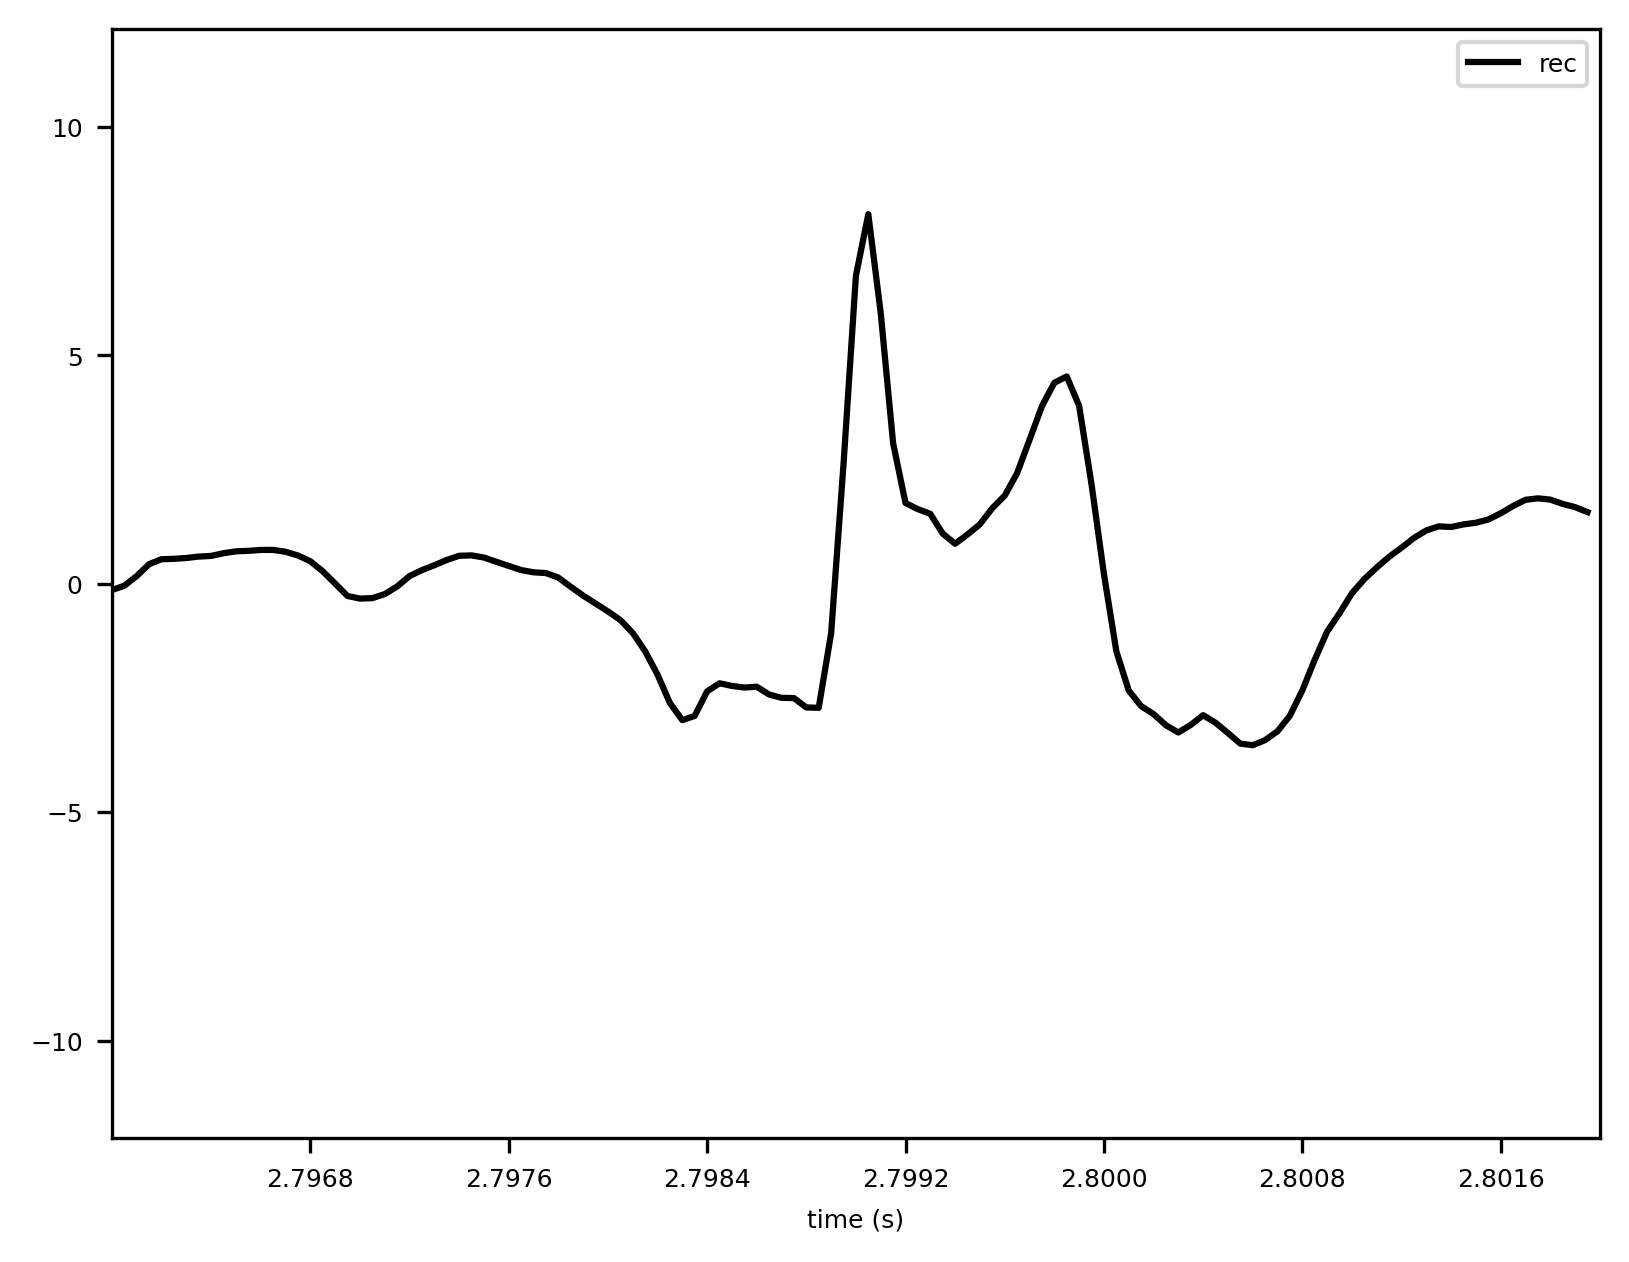

In [31]:
sw.plot_timeseries(rec0, channel_ids = [64],time_range = (2.796,2.802))

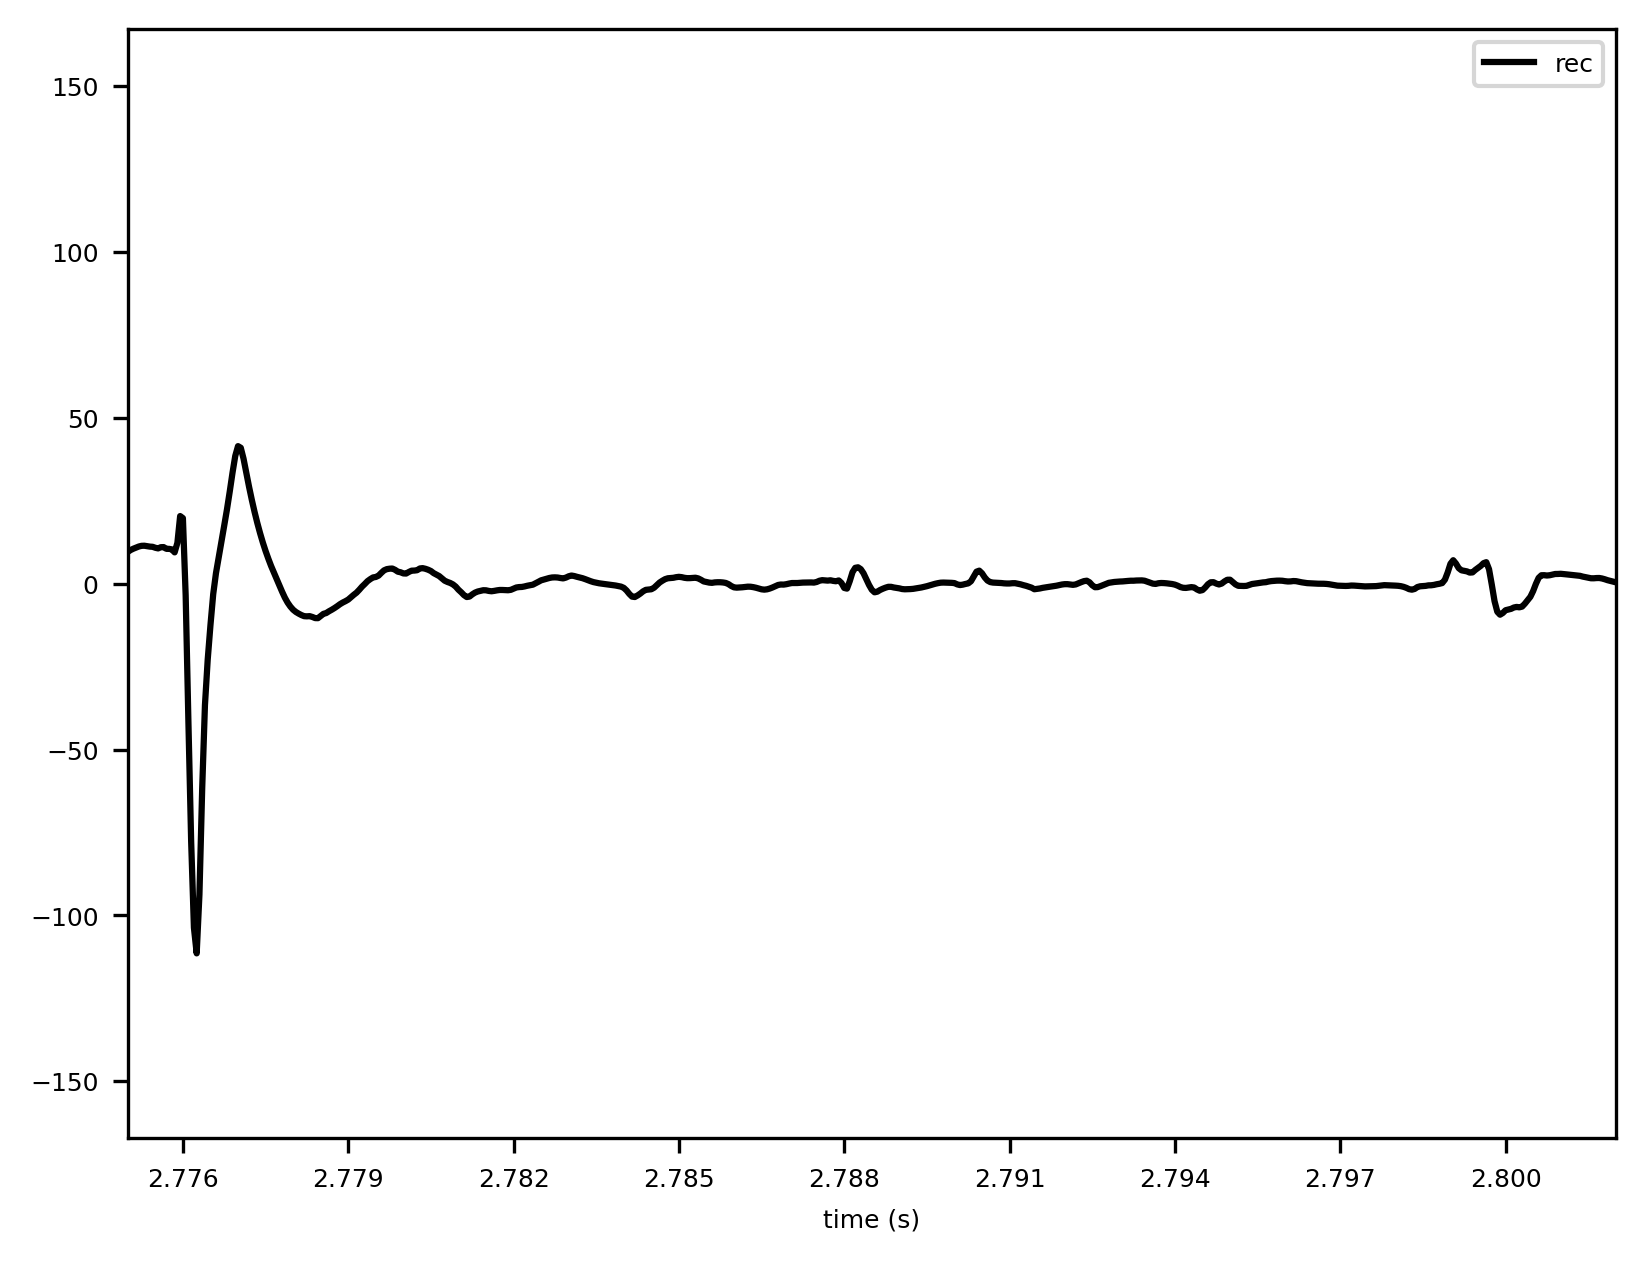

In [32]:
sw.plot_timeseries(rec0, channel_ids = [65],time_range = (2.775,2.802))

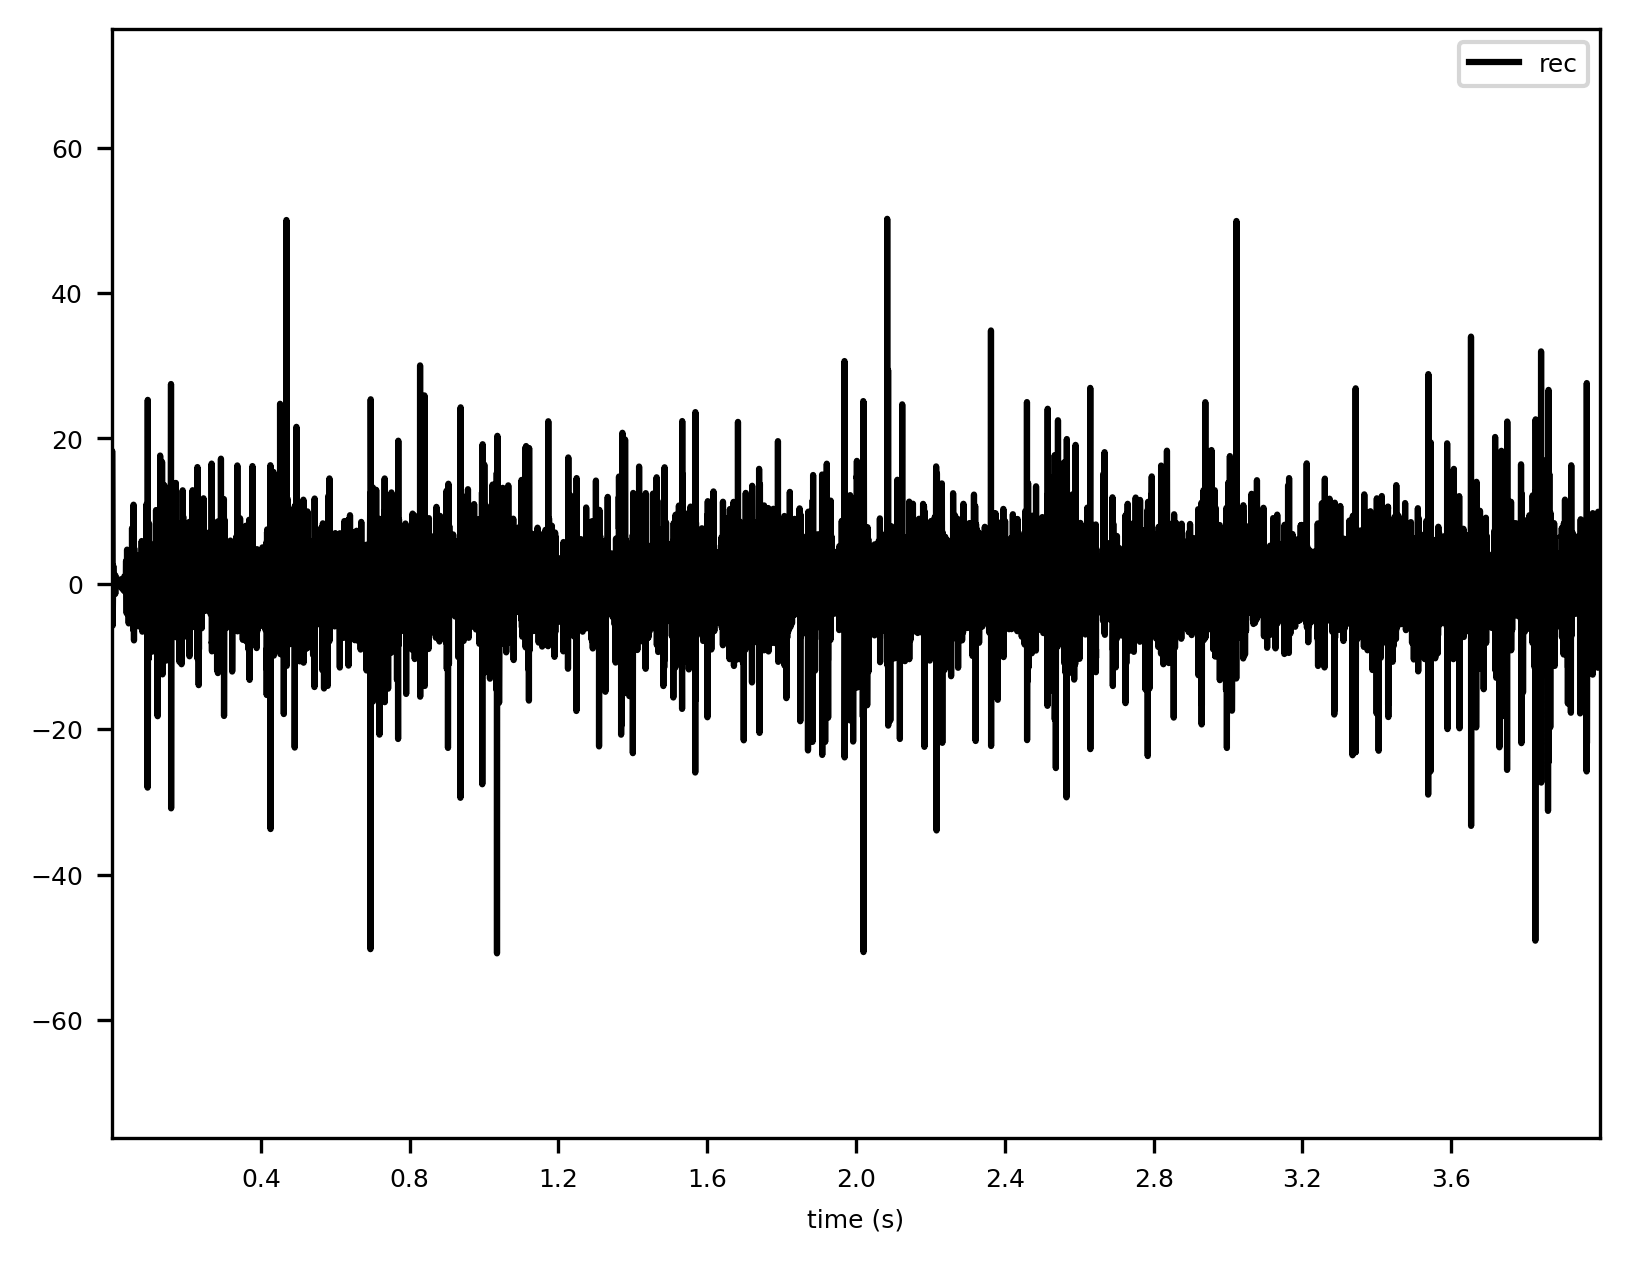

In [33]:
sw.plot_timeseries(rec0, channel_ids = [68],time_range = (0,4))

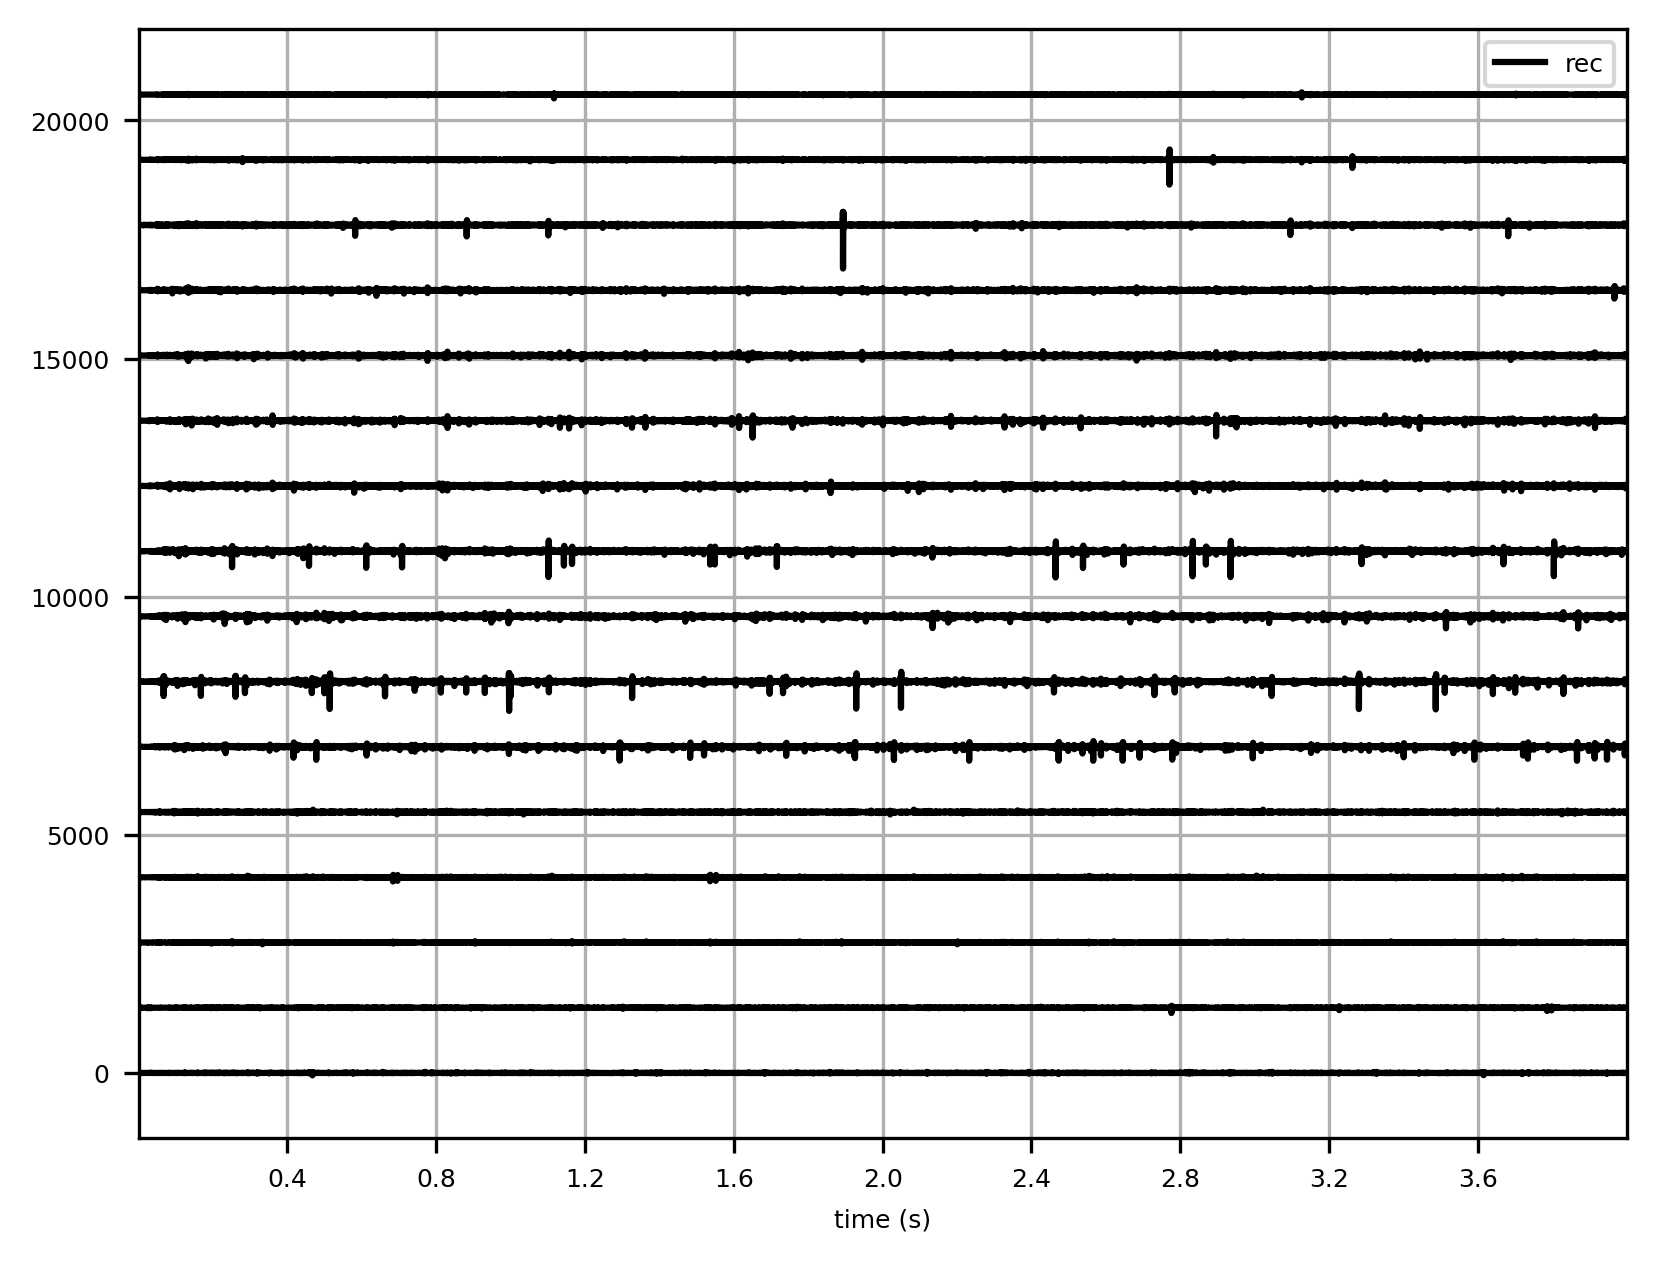

In [34]:
sw.plot_timeseries(rec, channel_ids = np.arange(64,80), time_range = (0,4))
plt.grid()

In [47]:
sorting_hd = study.get_sorting('hdsort')

In [48]:
study.compute_waveforms(rec0, ms_before = 2, ms_after = 2)

In [49]:
we = study.get_waveform_extractor(rec0)
gt = study.get_ground_truth(rec0)

8


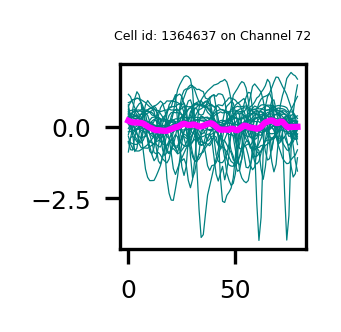

6


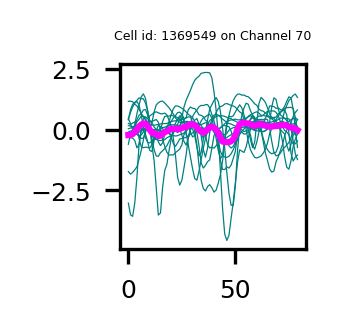

10


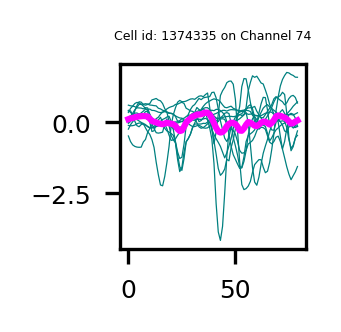

In [85]:
import numpy as np
SAMPLE = np.arange(0,3)

colors = ['Olive', 'Teal', 'Fuchsia']
max_chids = spost.get_template_extremum_channel(we, peak_sign='neg')
for i, unit_id in enumerate(gt.unit_ids[SAMPLE]):
    
    wf = we.get_waveforms(unit_id)
    
    idx = int(max_chids[unit_id]) - 64
    print(idx)
    
    plt.figure(figsize=(0.8,0.8));
    color = colors[1]
    plt.plot(wf[:, :, idx-1].T, color=color, lw=0.3)
    
    tmp = we.get_template(unit_id)
    plt.plot(tmp[:,idx-1], color = colors[2])
    plt.title(f"Cell id: {unit_id} on Channel {max_chids[unit_id]}", fontsize=3)
    plt.show()

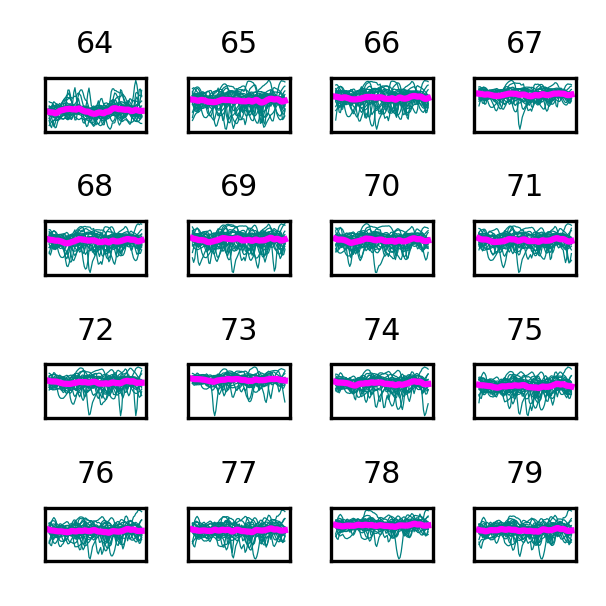

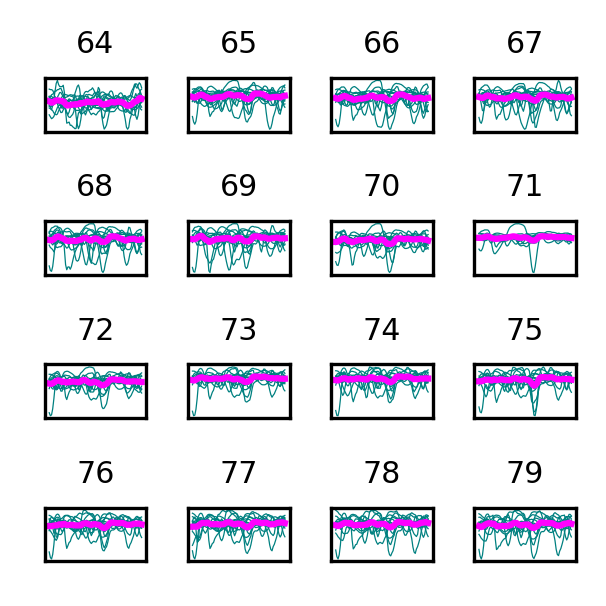

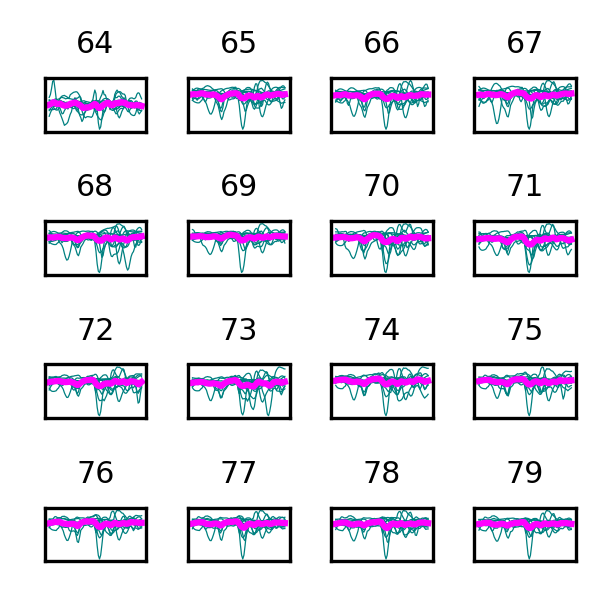

In [51]:
# real waveforms
colors = ['Olive', 'Teal', 'Fuchsia']
max_chids = spost.get_template_extremum_channel(we, peak_sign='neg')
for i, unit_id in enumerate(gt.unit_ids[SAMPLE]):
    wf = we.get_waveforms(unit_id)
    tmp = we.get_template(unit_id)
    color = colors[1]
    fig, ax = plt.subplots(4,4, figsize = (2,2))
    for idx in range(len(selected_channels)):
        ax = ax.flatten()
        ax[idx].plot(wf[:, :, idx-1].T, color=color, lw=0.3)
        ax[idx].plot(tmp[:,idx-1], color = colors[2])
        ax[idx].set_title(idx+selected_channels[0])
        ax[idx].get_yaxis().set_visible(False)
        ax[idx].get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [67]:
metrics = sqm.compute_quality_metrics(we)

/gpfs/bbp.cscs.ch/home/laquitai/spack_install/environments/test_env/.spack-env/._view/jrdt3tmavmwrfadpobleytnu5i5hs56w/lib/python3.9/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:404: UserWarning: Amplitude PDF does not have a unique minimum! More spikes might be required for a correct amplitude_cutoff computation!
  warnings.warn("Amplitude PDF does not have a unique minimum! More spikes might be required for a correct "


In [68]:
metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,amplitude_cutoff
1364637,29,7.250906,0.29,2.428091,0.000000,0.000000,0,0.008924
1369549,14,3.500438,0.14,3.993646,0.000000,0.000000,0,0.500000
1374335,11,2.750344,0.11,2.769150,0.000000,0.000000,0,0.023526
1996187,13,3.250406,0.13,6.738016,0.000000,0.000000,0,0.500000
2196191,18,4.500563,0.18,2.474184,0.000000,0.000000,0,0.500000
2202995,13,3.250406,0.13,4.576446,0.000000,0.000000,0,0.500000
2204870,15,3.750469,0.15,2.608108,0.000000,0.000000,0,0.017252
2884778,19,4.750594,0.19,1.934250,0.000000,0.000000,0,0.013620
3479424,11,2.750344,0.11,1.889780,0.000000,0.000000,0,0.500000
3489559,12,3.000375,0.12,6.570357,0.000000,0.000000,0,0.021565


In [69]:
probe = rec.get_probe()

In [70]:
probe.contact_positions[64]

array([ 3528.30275474, -1065.7025332 , -2641.78131262])